In [64]:
###################################第一部分########################################

In [65]:
import pandas_datareader as pdr  #利用pandas_datareader库获取苹果公司的最新股票信息
import pandas as pd              #利用pandas库将苹果公司的股票信息保存在EXCEL里面

In [66]:
#调用股票市场工具ttingo的API，获取信息
df=pdr.get_data_tiingo('AAPL',api_key='3bf49d7c00d719c5151350b494f0a992eb31a7b8') 
df.to_csv('AAPL.csv')   #转换为excel文件，保存
df=pd.read_csv('AAPL.csv') #将对应的excel文件读取出来

In [67]:
######################################################################################
######################################################################################
#测试代码，用以观测股票数据的规模和具体信息，便于接下来提取有用信息，进行训练

In [68]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-11-10 00:00:00+00:00,116.770,118.07,116.061,116.90,59127931,27.042599,27.343664,26.878402,27.072705,236511724,0.0,1.0
1,AAPL,2015-11-11 00:00:00+00:00,116.110,117.42,115.210,116.37,45217971,26.889750,27.193131,26.681320,26.949963,180871884,0.0,1.0
2,AAPL,2015-11-12 00:00:00+00:00,115.720,116.82,115.650,116.26,32525579,26.799431,27.054178,26.783219,26.924489,130102316,0.0,1.0
3,AAPL,2015-11-13 00:00:00+00:00,112.340,115.57,112.270,115.20,45812403,26.016661,26.764692,26.000450,26.679005,183249612,0.0,1.0
4,AAPL,2015-11-16 00:00:00+00:00,114.175,114.24,111.000,111.38,38106701,26.441626,26.456680,25.706333,25.794336,152426804,0.0,1.0


In [69]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2020-11-02 00:00:00+00:00,108.77,110.68,107.3200,109.11,122866899,108.582458,110.489164,107.134958,108.921871,122866899,0.000,1.0
1254,AAPL,2020-11-03 00:00:00+00:00,110.44,111.49,108.7300,109.66,107624448,110.249578,111.297768,108.542527,109.470923,107624448,0.000,1.0
1255,AAPL,2020-11-04 00:00:00+00:00,114.95,115.59,112.3500,114.14,138235482,114.751802,115.390699,112.156285,113.943199,138235482,0.000,1.0
1256,AAPL,2020-11-05 00:00:00+00:00,119.03,119.62,116.8686,117.95,126387074,118.824767,119.413750,116.667094,117.746629,126387074,0.000,1.0
1257,AAPL,2020-11-06 00:00:00+00:00,118.69,119.20,116.1300,118.32,114457922,118.690000,119.200000,116.130000,118.320000,114457922,0.205,1.0


In [70]:
######################################################################################
######################################################################################

In [71]:
df1=df.reset_index()['close']      #提取【close】列，只选取该股票的闭盘价格进行LSTM训练

In [72]:
######################################################################################
######################################################################################
#测试代码，用以观测待训练的数据

In [73]:
df1.shape

(1258,)

In [74]:
df1

0       116.770
1       116.110
2       115.720
3       112.340
4       114.175
         ...   
1253    108.770
1254    110.440
1255    114.950
1256    119.030
1257    118.690
Name: close, Length: 1258, dtype: float64

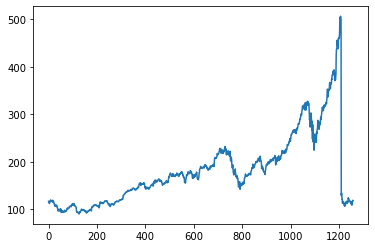

In [75]:
import matplotlib.pyplot as plt     #绘制苹果股票的闭盘价格图像，有一个直观的印象
plt.plot(df1)

In [76]:
### LSTM对数据的规模很敏感  我们需要对数据进行标准化处理————最小尺度

In [77]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [78]:
df1.shape

(1258, 1)

In [79]:
print(df1)

[[0.06357186]
 [0.06198437]
 [0.0610463 ]
 ...
 [0.05919423]
 [0.06900782]
 [0.06819002]]


In [80]:
###将数据集分为两部分，一部分是训练集（前3/4），另一部分是测试集（前1/4）
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:1],df1[training_size:len(df1),:1]

In [81]:
len(train_data),len(test_data)

(943, 315)

In [82]:
import numpy
#定义数据处理函数，将数组中的数据转变为待训练的数据矩阵
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]  #i=0 0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX),numpy.array(dataY)

In [83]:
time_step=100             ###用前100天的数据预测第101天的数据
X_train,Y_train=create_dataset(train_data,time_step)
X_test,Y_test=create_dataset(test_data,time_step)

In [84]:
X_train.shape,Y_train.shape

((842, 100), (842,))

In [85]:
##将数据转换为LSTM模型所需要的input
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [86]:
######################################################################################
######################################################################################
#创建LSTM模型，进行训练

In [87]:
###创建LSTM模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [88]:
model=Sequential()    #使用keras中的Sequential序贯模型,构建3层lstm神经网络，与1层Dense层
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=False))
model.add(Dense(1))  #进行维度变换，将LSTM的输出转换为所需输出
model.compile(loss='mean_squared_error',optimizer='adam')  #配置学习过程，定义loss函数为均方误差，并使用adam优化器对模型进行优化

In [89]:
model.summary()   ##利用model()函数，直观的观察LSTM模型的结构

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 100)          60400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 151,301
Trainable params: 151,301
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64,verbose=1)  ##进行训练

Train on 842 samples, validate on 214 samples
Epoch 1/100
842/842 [==============================] - 10s 11ms/sample - loss: 0.0072 - val_loss: 0.0319
Epoch 2/100
842/842 [==============================] - 5s 6ms/sample - loss: 9.5827e-04 - val_loss: 0.0315
Epoch 3/100
842/842 [==============================] - 4s 5ms/sample - loss: 3.8860e-04 - val_loss: 0.0277
Epoch 4/100
842/842 [==============================] - 5s 6ms/sample - loss: 3.2972e-04 - val_loss: 0.0267
Epoch 5/100
842/842 [==============================] - 5s 6ms/sample - loss: 3.0943e-04 - val_loss: 0.0259
Epoch 6/100
842/842 [==============================] - 5s 6ms/sample - loss: 3.0082e-04 - val_loss: 0.0251
Epoch 7/100
842/842 [==============================] - 6s 7ms/sample - loss: 3.0134e-04 - val_loss: 0.0244
Epoch 8/100
842/842 [==============================] - 5s 5ms/sample - loss: 2.7593e-04 - val_loss: 0.0232
Epoch 9/100
842/842 [==============================] - 5s 5ms/sample - loss: 2.6140e-04 - val_loss: 

In [91]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [92]:
###预测检验
train_predict=model.predict(X_train)     #利用训练出来的模型对训练集进行预测
test_predict=model.predict(X_test)       ##利用训练出来的模型对测试集进行预测

In [93]:
train_predict=scaler.inverse_transform(train_predict)   #将标准化处理的数据还原到原来的尺度
test_predict=scaler.inverse_transform(test_predict)     #将标准化处理的数据还原到原来的尺度

In [94]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))    #计算训练集的均值方差

162.36684546048724

In [95]:
math.sqrt(mean_squared_error(Y_test,test_predict))     #计算预测集的均值方差

295.91807026195914

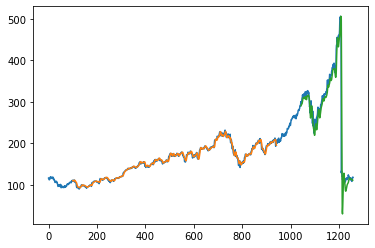

In [96]:
###观察训练效果，原始的蓝色曲线是数据集，橙色曲线是训练集的训练效果展示，绿色曲线是测试集的训练效果展示
look_back=100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [97]:
len(test_data)

315

In [98]:
X_input=test_data[215:].reshape(-1,1)   #取已知数据集的后一百天作为输入，预测第101天，依次向后预测

In [99]:
X_input.shape

(100, 1)

In [100]:
temp_input=list(X_input)
temp_input=temp_input[0].tolist()    #转换成所需的数据类型

In [101]:
temp_input

[0.628719182200842]

In [102]:
###预测未来15天的股票闭盘价格走势
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<15):
    if(len(temp_input)>100):
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input=X_input.reshape(1,-1)
        X_input=X_input.reshape((1,n_steps,1))
        yhat=model.predict(X_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        X_input=X_input.reshape((1,n_steps,1))
        yhat=model.predict(X_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

[0.05946534]
2
[0.05946534]
3
[0.05946534]
4
[0.05946534]
5
[0.05946534]
6
[0.05946534]
7
[0.05946534]
8
[0.05946534]
9
[0.05946534]
10
[0.05946534]
11
[0.05946534]
12
[0.05946534]
13
[0.05946534]
14
[0.05946534]
15
[0.05946534]
16
[[0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024], [0.05946534499526024]]


In [103]:
day_new=np.arange(1,101)
day_pred=np.arange(101,116)

In [104]:
import matplotlib.pyplot as plt

In [105]:
df2=df1.tolist()
df2.extend(lst_output)

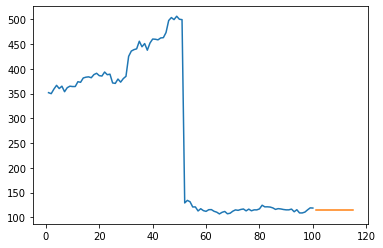

In [106]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))    ##将标准化的数据返回到原来的比例，并绘制曲线
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [107]:
history


import tensorflow as tf
tf.__version__
###预测检验
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
import pandas_datareader as pdr
df=pdr.get_data_tiingo('AAPL',api_key='3bf49d7c00d719c5151350b494f0a992eb31a7b8')
df.to_csv('AAPL.csv')
import pandas as pd
df=pd.read_csv('AAPL.csv')
df.head()
df.tail()
df1=df.reset_index()['close']
df1.shape
df1
import matplotlib.pyplot as plt
plt.plot(df1)
### LSTM对数据的规模很敏感  所以我们应用最小尺度
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape
print(df1)
###将数据集分为两部分，一部分是训练集，另一部分是测试集
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:1],df1[training_size:len(df1),:1]
len(train_data),len(test_data)
import numpy
#将数组中的数据转变为  待训练的数据矩阵
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_s